In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from glob import glob
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/distraction dataset/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
df.shape

(22424, 3)

In [ ]:
# Groupby subjects
by_drivers = df.groupby('subject')
#Group unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id

print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(df.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [ ]:
num_classes = 10

In [ ]:
#Read with opencv
def get_image(path, img_rows, img_cols, color_type=3):

    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

#Loading training dataset
def train_data_load(img_rows=64, img_cols=64, color_type=3):
    train_images=[]
    train_labels=[]

#Loop over the training folder
    for classes in tqdm(range(num_classes)):
        print('Loading directory c{}'.format(classes))
        files = glob(os.path.join('/content/drive/MyDrive/data/distraction dataset/train/c' + str(classes), '*.jpg'))
#         files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classes), '*.jpg'))
        for file in files:
            img = get_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classes)
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = train_data_load(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)

    return x_train, x_test, y_train, y_test


In [ ]:
#Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('/content/drive/MyDrive/data/distraction dataset/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id


In [ ]:
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [ ]:
pip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 606 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=93624f01acf1719227f37477577b4d5c8c5502a71241ff0e55784ec634b83429
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [ ]:
img_rows = 64
img_cols = 64
color_type = 1
nb_test_samples = 200

#Loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

#Loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)


  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:12<01:50, 12.32s/it]

Loading directory c1


 20%|██        | 2/10 [01:08<05:03, 37.97s/it]

Loading directory c2


 30%|███       | 3/10 [01:59<05:08, 44.09s/it]

Loading directory c3


 40%|████      | 4/10 [02:33<04:00, 40.12s/it]

Loading directory c4


 50%|█████     | 5/10 [03:19<03:31, 42.29s/it]

Loading directory c5


 60%|██████    | 6/10 [04:20<03:13, 48.41s/it]

Loading directory c6


 70%|███████   | 7/10 [05:15<02:32, 50.71s/it]

Loading directory c7


 80%|████████  | 8/10 [05:50<01:31, 45.72s/it]

Loading directory c8


 90%|█████████ | 9/10 [06:33<00:44, 44.94s/it]

Loading directory c9


 13%|█▎        | 200/1555 [00:16<01:51, 12.14it/s]


## Data Visualisation

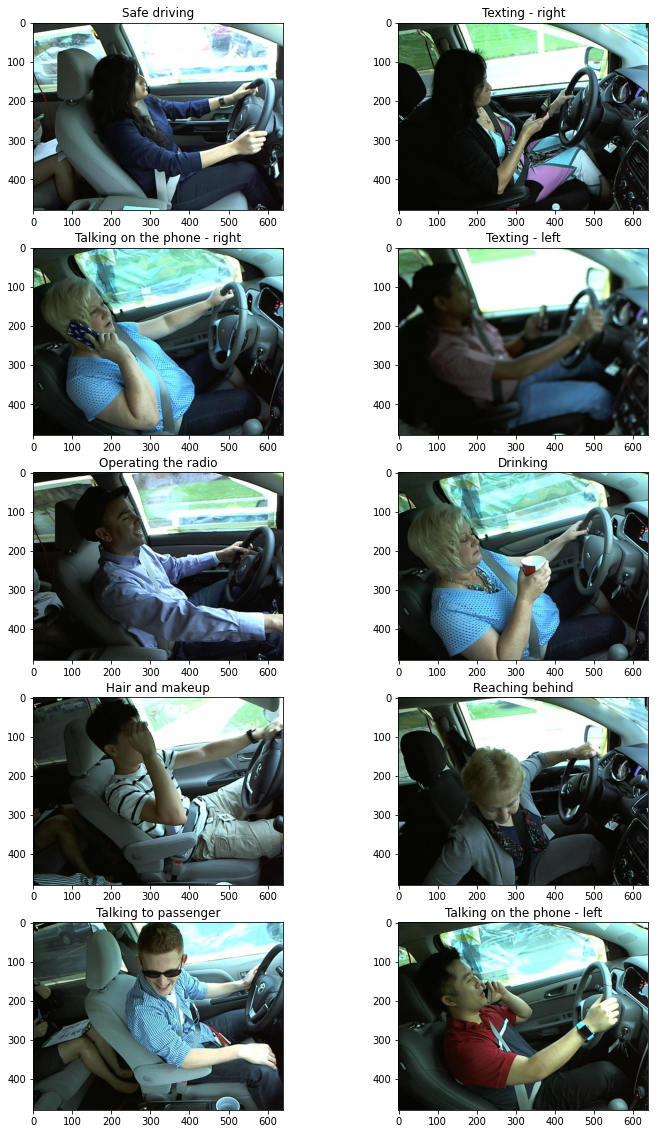

In [ ]:
driver_map = {'c0': 'Safe driving',
                'c1': 'Texting - right',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting - left',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

plt.figure(figsize = (12, 20))
image_count = 1

BASE_URL = '/content/drive/MyDrive/data/distraction dataset/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(driver_map[directory])


## Model Architecture - CNN

In [ ]:
batch_size = 40
n_epochs = 10

In [ ]:
def create_model():
  model = Sequential()

  #CNN1
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
  model.add(BatchNormalization())
  model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(axis=3))
  model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
  model.add(Dropout(0.3))

 #CNN2
  model.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(axis=3))
  model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
  model.add(Dropout(0.3))

  #CNN3
  model.add(Conv2D(128, (3,3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(axis=3))
  model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
  model.add(Dropout(0.3))

  #flatten output
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(10,activation='softmax'))


  return model



In [ ]:
model = create_model()

#Details about the model
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                        

In [ ]:
history=model.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=n_epochs, batch_size=batch_size, verbose=1)
print('History of the training',history.history)

Epoch 1/10
408/408 [==============================] - 295s 718ms/step - loss: 1.0693 - accuracy: 0.6604 - val_loss: 0.9009 - val_accuracy: 0.7892
Epoch 2/10
408/408 [==============================] - 281s 689ms/step - loss: 0.2628 - accuracy: 0.9178 - val_loss: 0.9357 - val_accuracy: 0.7261
Epoch 3/10
408/408 [==============================] - 282s 692ms/step - loss: 0.1494 - accuracy: 0.9536 - val_loss: 0.1321 - val_accuracy: 0.9602
Epoch 4/10
408/408 [==============================] - 281s 690ms/step - loss: 0.1111 - accuracy: 0.9655 - val_loss: 0.0613 - val_accuracy: 0.9850
Epoch 5/10
408/408 [==============================] - 282s 690ms/step - loss: 0.0810 - accuracy: 0.9746 - val_loss: 0.1141 - val_accuracy: 0.9644
Epoch 6/10
408/408 [==============================] - 282s 692ms/step - loss: 0.0571 - accuracy: 0.9818 - val_loss: 0.0750 - val_accuracy: 0.9816
Epoch 7/10
408/408 [==============================] - 284s 696ms/step - loss: 0.0556 - accuracy: 0.9827 - val_loss: 0.0893 -

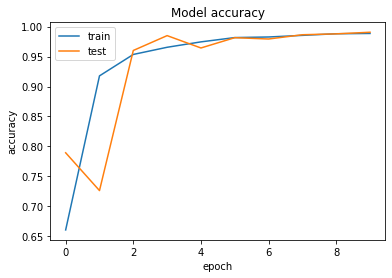

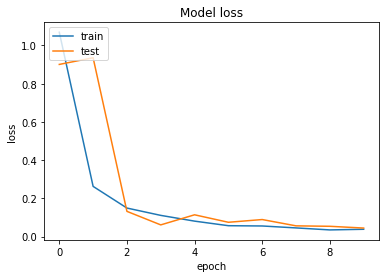

In [ ]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_train_history(history)

## Prediction

In [ ]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(driver_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()

In [ ]:
score1 = model.evaluate(x_test, y_test, verbose=1)

128/128 [==============================] - 17s 135ms/step - loss: 0.0448 - accuracy: 0.9907


In [ ]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.04475156217813492
Accuracy:  99.06656742095947  %


1/1 [==============================] - 0s 36ms/step
Y prediction: [[1.0633066e-09 3.2105692e-12 2.3491870e-10 5.8005700e-10 6.2435052e-10
  1.0000000e+00 1.3538501e-10 8.9412033e-11 1.4491575e-09 4.5298378e-09]]
Predicted: Operating the radio


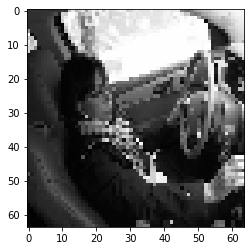

1/1 [==============================] - 0s 48ms/step
Y prediction: [[9.8789783e-08 7.4653698e-08 7.0338743e-03 1.2358338e-05 8.1567290e-05
  9.9267250e-01 1.4412930e-04 2.4931801e-06 3.3336339e-05 1.9447345e-05]]
Predicted: Operating the radio


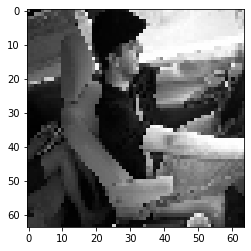

1/1 [==============================] - 0s 51ms/step
Y prediction: [[1.3349097e-02 5.4682720e-02 1.1714499e-03 2.2241779e-04 2.0465257e-03
  3.8626982e-05 7.0932704e-01 9.1325353e-05 9.8744363e-02 1.2032643e-01]]
Predicted: Drinking


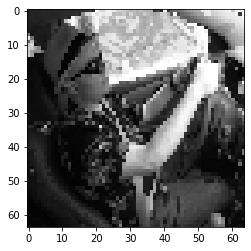

1/1 [==============================] - 0s 56ms/step
Y prediction: [[2.9452136e-04 6.2405582e-07 4.9331959e-04 6.7594160e-06 5.7408943e-06
  3.7616814e-05 4.2261445e-04 3.6800702e-06 9.9842703e-01 3.0813779e-04]]
Predicted: Hair and makeup


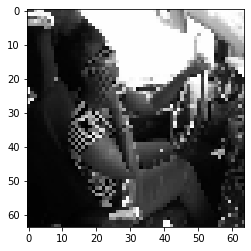

1/1 [==============================] - 0s 32ms/step
Y prediction: [[4.3017108e-06 1.5369132e-08 8.5314969e-07 7.1648157e-07 5.1722759e-07
  9.9981791e-01 1.3101447e-06 3.3871817e-08 1.5513357e-04 1.9186946e-05]]
Predicted: Operating the radio


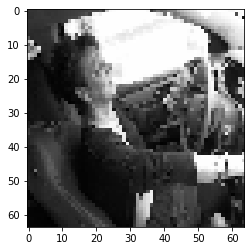

1/1 [==============================] - 0s 45ms/step
Y prediction: [[5.1860383e-07 5.7374425e-11 1.3089187e-08 1.6926718e-08 3.4667501e-06
  9.9999464e-01 8.1538589e-09 7.6207061e-11 1.3233442e-06 4.6002636e-08]]
Predicted: Operating the radio


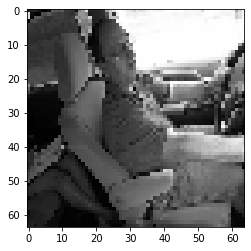

1/1 [==============================] - 0s 34ms/step
Y prediction: [[6.3657621e-06 2.9982693e-05 1.4506520e-02 1.9471837e-07 6.9740308e-05
  4.3538880e-06 9.8537755e-01 2.1420593e-07 3.5136975e-06 1.5182778e-06]]
Predicted: Drinking


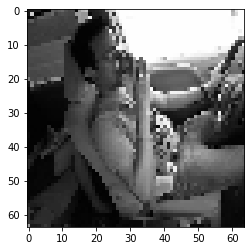

1/1 [==============================] - 0s 42ms/step
Y prediction: [[9.0309879e-07 1.6798077e-06 3.7417434e-05 2.3250921e-07 2.7650719e-06
  6.2405766e-06 4.3294891e-05 5.9817216e-06 9.9988353e-01 1.7894246e-05]]
Predicted: Hair and makeup


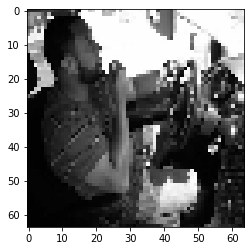

1/1 [==============================] - 0s 30ms/step
Y prediction: [[1.1427567e-02 9.6321577e-04 9.9828923e-03 6.7754346e-03 1.4446184e-02
  1.3179819e-03 9.3876439e-01 4.0507842e-07 1.3237892e-02 3.0839338e-03]]
Predicted: Drinking


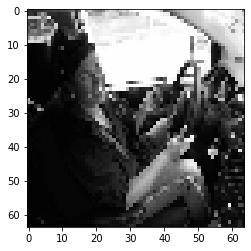

1/1 [==============================] - 0s 65ms/step
Y prediction: [[2.7057665e-09 2.6961649e-12 1.0517257e-07 1.4260054e-08 5.2396811e-09
  9.9999988e-01 2.5804045e-08 5.6591218e-11 9.6881152e-09 1.7064600e-09]]
Predicted: Operating the radio


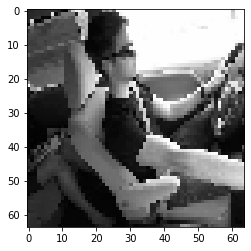

In [ ]:
for i in range(10):
    plot_test_class(model, test_files, i)

despite having achieved such a high accuracy for both train and validation sets, the predictions on the unlabeled test dataset is no where near accurate.This is due to the fact that the training data has multiple images of the same person with minor variations which caused a data leakage ie the training was done with much of the same images.

## Data Augmention

In [ ]:
#using image generator

train_gen  = ImageDataGenerator(rescale = 1.0/255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                   validation_split = 0.2)

test_gen = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.2)



In [ ]:
nb_train_samples = x_train.shape[1]
nb_validation_samples = x_test.shape[1]
training_generator = train_gen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_gen.flow(x_test, y_test, batch_size=batch_size)

In [ ]:
history_v2 = model.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples,
                         epochs = n_epochs,
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


64/64 [==============================] - 54s 848ms/step - loss: 1.4686 - accuracy: 0.5654 - val_loss: 62.6238 - val_accuracy: 0.1109
Epoch 2/10
64/64 [==============================] - 53s 827ms/step - loss: 1.0469 - accuracy: 0.6459 - val_loss: 52.3754 - val_accuracy: 0.1219
Epoch 3/10
64/64 [==============================] - 53s 834ms/step - loss: 0.8506 - accuracy: 0.7191 - val_loss: 35.4036 - val_accuracy: 0.0996
Epoch 4/10
64/64 [==============================] - 55s 856ms/step - loss: 0.7700 - accuracy: 0.7586 - val_loss: 53.7915 - val_accuracy: 0.0980
Epoch 5/10
64/64 [==============================] - 55s 857ms/step - loss: 0.6304 - accuracy: 0.7926 - val_loss: 58.9634 - val_accuracy: 0.0965
Epoch 6/10
64/64 [==============================] - 54s 852ms/step - loss: 0.5973 - accuracy: 0.8074 - val_loss: 76.8363 - val_accuracy: 0.0902
Epoch 7/10
64/64 [==============================] - 55s 857ms/step - loss: 0.5050 - accuracy: 0.8324 - val_loss: 42.4457 - val_accuracy: 0.1000
Epo

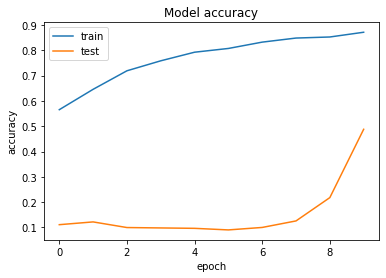

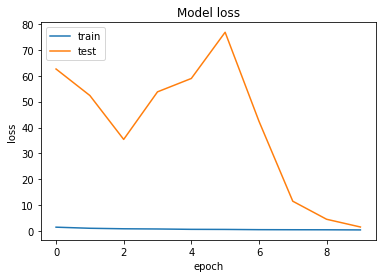

In [ ]:
plot_train_history(history_v2)

In [ ]:
score2 = model.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Loss for model 1",score1[0])
print("Loss for model 2 (data augmentation):", score2[0])

print("Test accuracy for model 1",score1[1])
print("Test accuracy for model 2 (data augmentation):", score2[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss for model 1 0.04475156217813492
Loss for model 2 (data augmentation): 1.50894296169281
Test accuracy for model 1 0.9906656742095947
Test accuracy for model 2 (data augmentation): 0.5


In [ ]:
# import pickle
# with open('ml_model','wb') as f:
#   pickle.dump(model,f)